In [90]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
#from model3D import *
from model3D_small import *
import math
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils  import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import offsetbox
from tensorflow.keras.applications.resnet50 import ResNet50
import visualkeras
from keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
from sklearn.manifold import TSNE
from PIL import Image
from matplotlib.patches import Patch
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [91]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [92]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


In [93]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

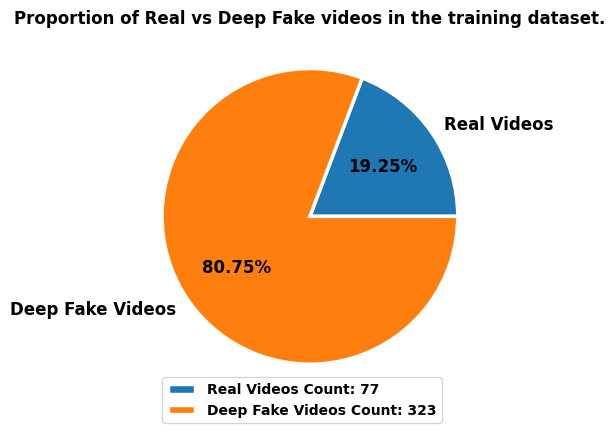

In [94]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

## Frames

In [138]:
def get_faces(paths: list, face_amount: int,colors:bool=False) -> (np.ndarray, list):
    video_array = []
    invalid_indices = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for idx, path in enumerate(tqdm(paths)):
        vc = cv2.VideoCapture(path)

        faces = []
        while len(faces) < face_amount:
            ret, frame = vc.read()
            if ret and frame is not None:
                col_frame = frame    
                if(colors==False):
                    col_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                else:
                    col_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face = face_cascade.detectMultiScale(col_frame, minSize=(109, 109), minNeighbors=7)
                if len(face) > 0:
                    x, y, w, h = max(face, key=lambda x: x[2] * x[3])
                    face_img = col_frame[y:y+h, x:x+w]
                    face_img = cv2.resize(face_img, (224, 224))
                    if(colors==False):
                        face_img = face_img / 255
                    faces.append(face_img)
            else:
                break
        vc.release()
        if len(faces) == face_amount:
            video_array.append(np.array(faces))
        else:
            invalid_indices.append(idx)
    if(colors==False):
        returnArray = np.expand_dims(np.array(video_array), axis=-1)
    else:
        returnArray = np.array(video_array)
    return returnArray, invalid_indices

In [96]:
# Run this codeblook if you just want to get the faces and save the np array
training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []

for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
complete_paths.sort()

(grey_faces, indices) = get_faces(complete_paths, 5)
#np.savez_compressed('data/greyscale.npy', faces)

100%|██████████| 400/400 [03:17<00:00,  2.03it/s]


In [97]:
# Run this codeblook if you just want to get the preloaded data
#data = np.load('data/greyscale.npy.npz')

# access the array data
#faces = data['arr_0']
#indices = [41, 55, 58, 71, 79, 80, 83, 90, 103, 120, 121, 143, 159, 166, 170, 187, 190, 203, 205, 212, 232, 245, 270, 275, 282, 285, 301, 309, 310, 314, 322, 324, 331, 332, 355, 357, 366, 372, 375, 379, 380, 392]

In [139]:
(color_faces, color_indices) = get_faces(complete_paths, 1,True)

100%|██████████| 400/400 [02:39<00:00,  2.51it/s]


In [99]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y = np.array(y)
y = np.delete(y, indices)

## t-SNE

In [100]:
num_videos, num_frames, face_width, face_height, num_channels = color_faces.shape
flattened_size = face_width * face_height * num_channels
# Reshape the faces array to a 2D array
faces_reshaped = color_faces.reshape(num_videos * num_frames, flattened_size)
tsne = TSNE(n_components=2, random_state=42,perplexity=25)
faces_embedded = tsne.fit_transform(faces_reshaped)

Below plots the faces as thumbnails. Using images is done quite alot using the t-sne technique. The library used for this is https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. First we extract the shape information from color_faces. We then give the values extract some variables names. Then we use these values to calculate the flatten size. After that we reshape the data into 2D also called flatting. The reason for this is that t-sne expects it in a specific format. The ax.set_xlim(tsne_results[:, 0].min() - 10, tsne_results[:, 0].max() + 10) and ax.set_ylim(tsne_results[:, 1].min() - 10, tsne_results[:, 1].max() + 10) finds the lower and upper bound.

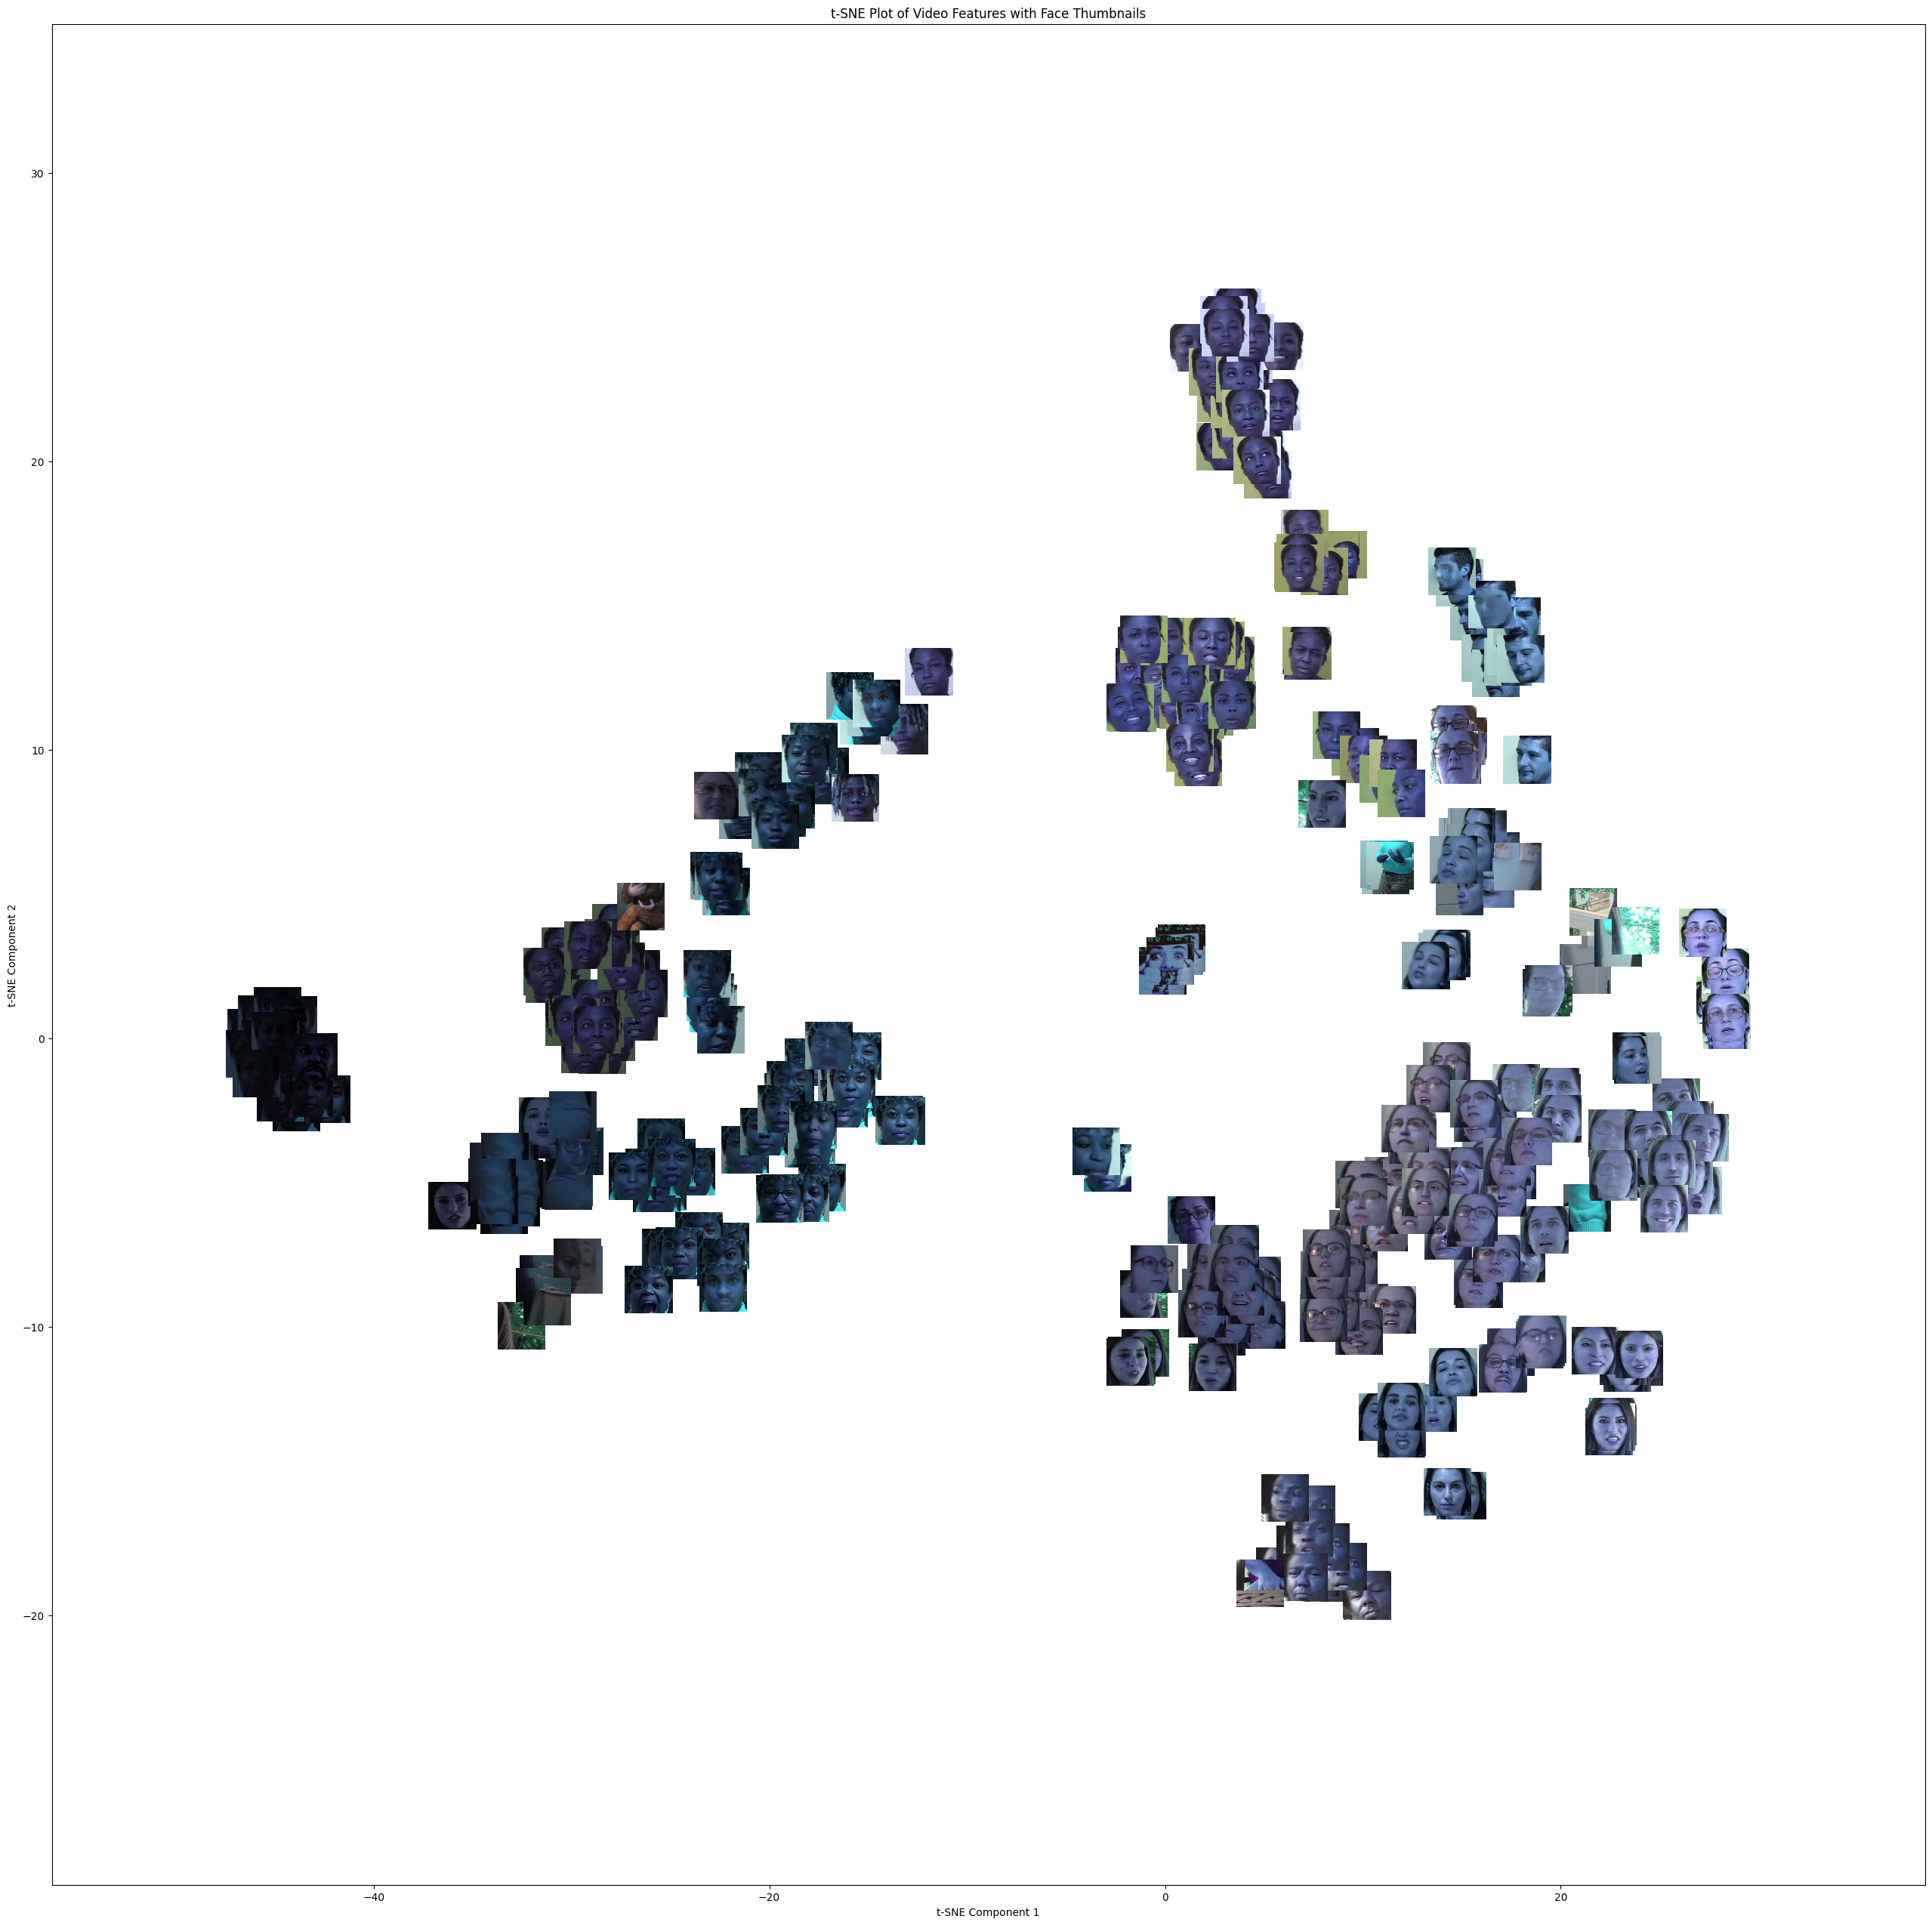

In [101]:
def plot_tsne_with_images(tsne_results, face_regions, figsize=(32, 32)):
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(tsne_results.shape[0]):
        x, y = tsne_results[i, :]

        img = face_regions[i]

        img_box = offsetbox.OffsetImage(img, zoom=0.2)
        img_annotation = offsetbox.AnnotationBbox(img_box, (x, y), xycoords='data', frameon=False)

        ax.add_artist(img_annotation)

    ax.set_xlim(tsne_results[:, 0].min() - 10, tsne_results[:, 0].max() + 10)
    ax.set_ylim(tsne_results[:, 1].min() - 10, tsne_results[:, 1].max() + 10)
    ax.set_title('t-SNE Plot of Video Features with Faces')
    plt.show()

plot_tsne_with_images(faces_embedded, color_faces.reshape(num_videos * num_frames, face_width, face_height, num_channels))

## Logistic regression

In [102]:
X = grey_faces
X = np.reshape(X, (X.shape[0], X.shape[1], -1)) # X is your video dataset
X = X.reshape(X.shape[0]*X.shape[1], -1)
X = np.reshape(X, (X.shape[0] // 5, 5 * X.shape[1]))

train_size = 0.7
Y = y           

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=train_size, random_state=42)

test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size, random_state=42)

In [103]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
model = LogisticRegression(solver='sag', max_iter=1000, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_accuracy = model.score(X_valid, y_valid)
print('Validation accuracy:', val_accuracy)

# Predict the labels for the test set
y_pred = model.predict(X_test)


Validation accuracy: 0.7575757575757576


c:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [104]:
def plot_confusion_matrix(pred_y, actual_y) -> None:
    print(classification_report(actual_y, pred_y, digits=3))
    cfm = confusion_matrix(actual_y, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
    disp.plot()

              precision    recall  f1-score   support

           0      0.143     0.062     0.087        16
           1      0.795     0.906     0.847        64

    accuracy                          0.738        80
   macro avg      0.469     0.484     0.467        80
weighted avg      0.664     0.738     0.695        80



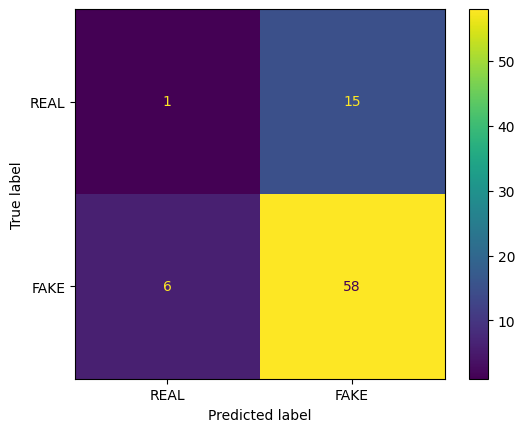

In [105]:
plot_confusion_matrix(y_pred, y_test)

## 2D model

In [140]:
y_color = [0 if val!="FAKE" else 1 for val in labels_col ]
y_color = np.array(y_color)
y_color = np.delete(y_color, color_indices)
y_color = to_categorical(y_color, num_classes=None).astype(int)

In [141]:
faces_2d = color_faces[:,0,:,:,:]
train_size = 0.7
X = faces_2d    # dataset of faces
Y = y_color           # labels

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=train_size)

test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(261, 224, 224, 3) (261, 2)
(80, 224, 224, 3) (80, 2)
(33, 224, 224, 3) (33, 2)


In [142]:
from keras.layers import GlobalAveragePooling2D, Dense

def build_2D_model_nb(input_data):
    base_model = ResNet50(include_top=False, input_shape=input_data.shape[1:])
    
    # Adding layers for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="sigmoid")(x)
    
    # Creating a new model with the additional layers
    model = keras.Model(inputs=base_model.input, outputs=x)
    
    return model
def compile_2D_model(model, lr):
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    metrics=["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [143]:
learning_rate= 0.0001
model_2d = build_2D_model_nb(X_train)
compiled_model = compile_2D_model(model_2d, learning_rate)
model_2d.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [131]:
print(X_train.shape,y_train.shape)

(264, 224, 224, 3) (264, 2)


In [144]:
from keras.preprocessing.image import ImageDataGenerator
# Train the model using fit_generator
history = compiled_model.fit(
    X_train, 
    y_train,
    epochs=10,
    batch_size=32, 
    verbose=2,
    validation_data=(X_valid, y_valid),
)

Epoch 1/10
9/9 - 56s - loss: 0.5218 - accuracy: 0.7701 - val_loss: 0.6927 - val_accuracy: 0.7879 - 56s/epoch - 6s/step
Epoch 2/10
9/9 - 42s - loss: 0.1211 - accuracy: 0.9693 - val_loss: 1.3488 - val_accuracy: 0.7879 - 42s/epoch - 5s/step
Epoch 3/10
9/9 - 42s - loss: 0.0502 - accuracy: 0.9962 - val_loss: 1.8353 - val_accuracy: 0.7879 - 42s/epoch - 5s/step
Epoch 4/10
9/9 - 43s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.1591 - val_accuracy: 0.7879 - 43s/epoch - 5s/step
Epoch 5/10
9/9 - 41s - loss: 0.0128 - accuracy: 1.0000 - val_loss: 2.0565 - val_accuracy: 0.7879 - 41s/epoch - 5s/step
Epoch 6/10
9/9 - 42s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 2.0161 - val_accuracy: 0.7879 - 42s/epoch - 5s/step
Epoch 7/10
9/9 - 43s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 2.2507 - val_accuracy: 0.7879 - 43s/epoch - 5s/step
Epoch 8/10
9/9 - 41s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 2.6615 - val_accuracy: 0.7879 - 41s/epoch - 5s/step
Epoch 9/10
9/9 - 43s - loss: 0.0057 - accuracy: 

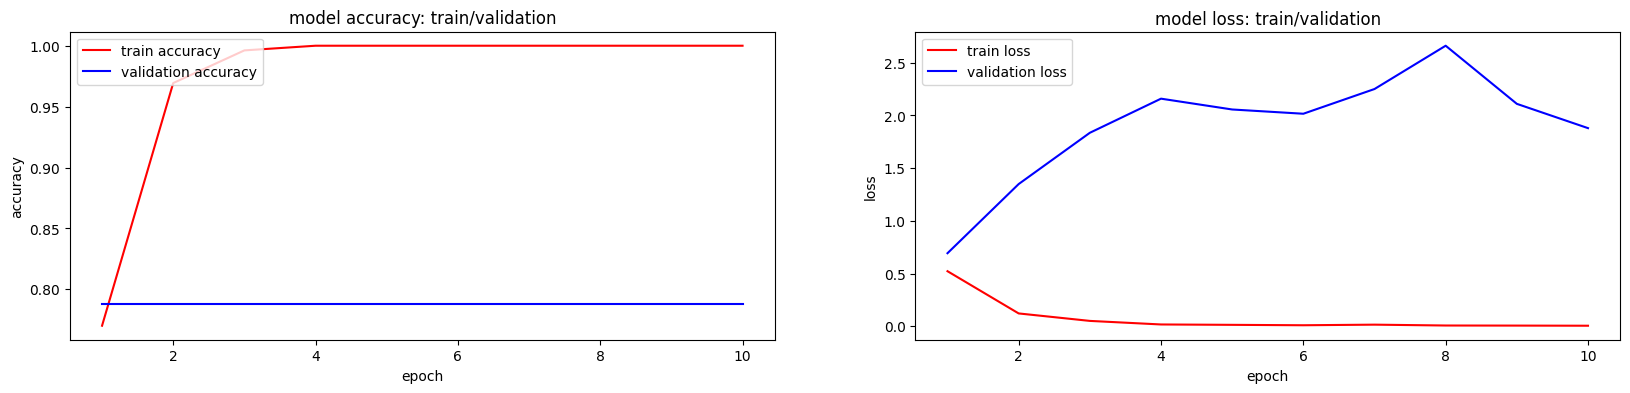

In [145]:
plot_training_history(history)

3/3 [==============================] - 4s 930ms/step
              precision    recall  f1-score   support

           0      0.800     0.250     0.381        16
           1      0.840     0.984     0.906        64

    accuracy                          0.838        80
   macro avg      0.820     0.617     0.644        80
weighted avg      0.832     0.838     0.801        80



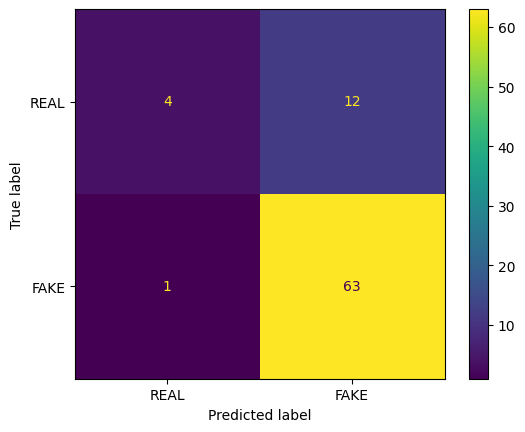

In [146]:
pred_y = compiled_model.predict(X_test)
actual_y = np.argmax(y_test, axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))
cfm = confusion_matrix(actual_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()

## 3D model

In [114]:
(grey_faces, indices) = get_faces(complete_paths, 5)

100%|██████████| 400/400 [04:20<00:00,  1.54it/s]


In [115]:
train_size = 0.7
X = grey_faces    # dataset of faces
Y = y           # labels

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=train_size, random_state=42)

test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size, random_state=42)


In [116]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)
class_weights = dict(zip(np.unique(y_train), weight_class))
class_weights

{0: 2.71875, 1: 0.6126760563380281}

In [117]:
def build_3D_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=32, kernel_size=3, padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1 ,activation="sigmoid"))
    return model

def compile_3D_model(model, lr):
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    metrics=["accuracy"]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [118]:
# Build and comple the model if 
model_3d = build_3D_model(grey_faces)
model_3d.summary()
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
model_3d.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 5, 224, 224, 32)   896       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 112, 112, 32)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 56, 56, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 28, 28, 128)  

In [119]:
# Train the model
history_test = model_3d.fit(X_train, 
                          y_train,
                          epochs=40, 
                          batch_size=32,
                          verbose=1,
                          class_weight=class_weights,
                          validation_data=(X_valid, y_valid)
)

Epoch 1/40
9/9 [==============================] - 453s 49s/step - loss: 0.7948 - accuracy: 0.3831 - val_loss: 0.6999 - val_accuracy: 0.3333
Epoch 2/40
9/9 [==============================] - 149s 16s/step - loss: 0.6954 - accuracy: 0.3678 - val_loss: 0.6917 - val_accuracy: 0.6970
Epoch 3/40
9/9 [==============================] - 147s 16s/step - loss: 0.6925 - accuracy: 0.4521 - val_loss: 0.7043 - val_accuracy: 0.3030
Epoch 4/40
9/9 [==============================] - 144s 16s/step - loss: 0.7067 - accuracy: 0.2414 - val_loss: 0.6872 - val_accuracy: 0.7273
Epoch 5/40
9/9 [==============================] - 144s 16s/step - loss: 0.6917 - accuracy: 0.5096 - val_loss: 0.6850 - val_accuracy: 0.7576
Epoch 6/40
9/9 [==============================] - 145s 16s/step - loss: 0.6881 - accuracy: 0.6169 - val_loss: 0.6950 - val_accuracy: 0.4545
Epoch 7/40
9/9 [==============================] - 148s 16s/step - loss: 0.7242 - accuracy: 0.4828 - val_loss: 0.6785 - val_accuracy: 0.7273
Epoch 8/40
9/9 [====

In [120]:
#model_3d.save('model_3D.h5')

In [121]:
# Load from earlier training
#from keras.models import load_model
#model_3d = load_model('model_3D.h5')

In [122]:
def plot_training_history(history_test) -> None:
    acc = history_test.history['accuracy']
    val_acc = history_test.history['val_accuracy']
    loss = history_test.history['loss']
    val_loss = history_test.history['val_loss']
    epochs = np.arange(1,len(history_test.history['accuracy'])+1)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 2, 1)
    plt.title(f'model accuracy: train/validation')
    plt.plot(epochs, acc, color="red", label="Training Acc")
    plt.plot(epochs, val_acc, color="blue", label="Validation Acc")
    plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.subplot(1, 2, 2)
    plt.title(f'model loss: train/validation')
    plt.plot(epochs, loss, color="red", label="Loss Acc")
    plt.plot(epochs, val_loss, color="blue", label="Loss Acc")
    plt.legend(['train loss', 'validation loss'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')

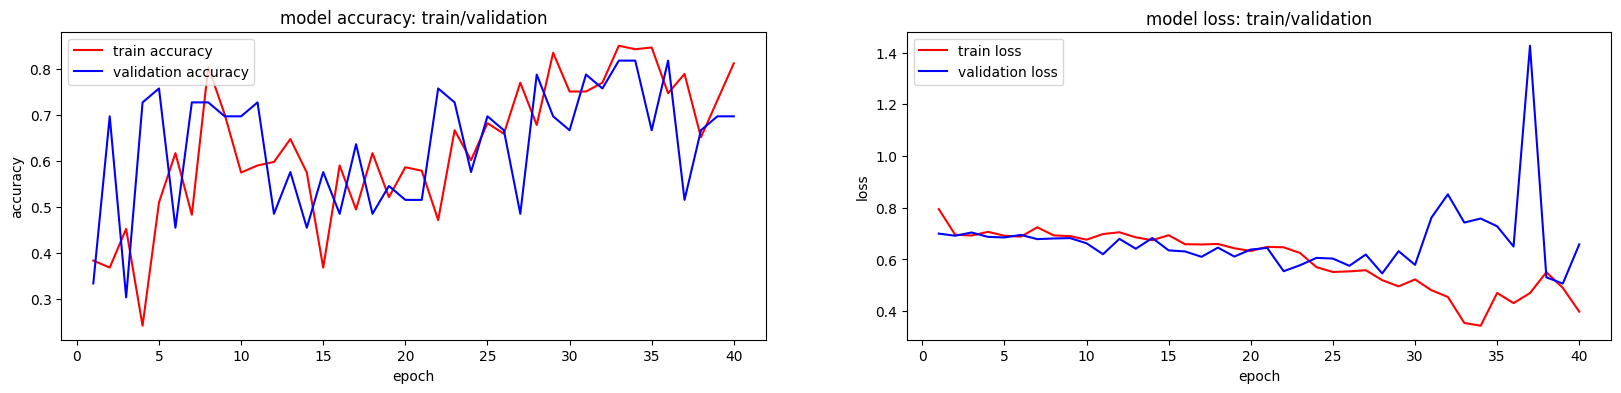

In [123]:
plot_training_history(history_test)

3/3 [==============================] - 3s 935ms/step
              precision    recall  f1-score   support

           0      0.200     0.250     0.222        16
           1      0.800     0.750     0.774        64

    accuracy                          0.650        80
   macro avg      0.500     0.500     0.498        80
weighted avg      0.680     0.650     0.664        80



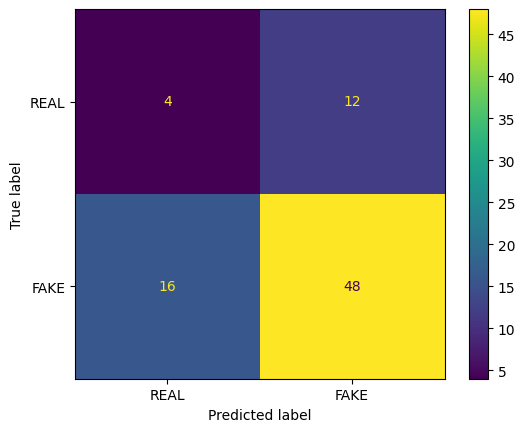

In [126]:
pred_y = np.round(model_3d.predict(X_test),0)
actual_y = y_test
plot_confusion_matrix(pred_y, actual_y)